In [0]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data 

In [2]:
#read data and display data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True) # we will use one hot encoding, every outputclass is a separate dimension

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [3]:
print(mnist.train.images.shape)
print(mnist.train.labels.shape) # we have train images and train labels
print(mnist.test.images.shape)
print(mnist.test.labels.shape) # ans separate test iamges and labels for evaluation
#print(mnist.train.images[0,:])
mnist.train.labels[0]

(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

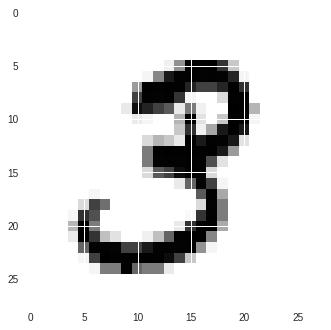

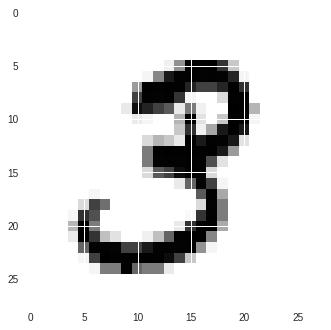

In [4]:
#display an image just to get a feel what we are working on
import matplotlib.pyplot as plt
img= np.reshape(mnist.train.images[1,:],[28,28])

#notebook
fig,ax =plt.subplots()
ax.imshow(img,cmap="Greys")
display(fig)

#python script
plt.imshow(img,cmap="Greys")
plt.show()

In [0]:
#the parameters of the algorithm
BatchLength= 128  #batches of 32 images are processed and averaged out
Size=[28,28,1]  #size of the input image
NumIteration=201 #we will run just a few itereations- you can run it longer at home
LearningRate=1e-4 #initial learning rate
NumClasses = 10 #number of possible output classes
EvalFreq = 10 # we will evaluate at every 1000 step

In [4]:
tf.reset_default_graph() #reset the graph
InputData = tf.placeholder(tf.float32, [None]+Size )  #input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses]) #the expected outputs, labels
print(InputData)
NumKernels=[32,32,32] #a list that defines the number of layers and how many convolution kernels we have at each layer

def AddBoundedLeakyRelu(x):
    alpha=0.01
    R=tf.maximum(-1 + alpha*(x+1),x)
    R=tf.minimum(1 + alpha*(R-1),R)
    return R

def BaseLineNetwork(Input):
  CurrentFilters=Size[2]
  LayerNum=0
  CurrentInput=Input
  # a loop which creates all layers
  for N in NumKernels:
      with tf.variable_scope('baselineconv'+str(LayerNum)):
        LayerNum+=1
        #variables that we want to optimize
        W =tf.get_variable('W', [3,3,CurrentFilters,N])
        Bias = tf.get_variable('Bias', [N],initializer=tf.constant_initializer(0.0))
        #convolution
        ConvResult = tf.nn.conv2d(CurrentInput,W,strides=[1,1,1,1], padding='VALID')
        CurrentFilters=N
        #we adda bias
        ConvResult = tf.add(ConvResult,Bias)
        print(ConvResult)
        # relu
        ReLU=tf.nn.relu(ConvResult)
        #pool
        Pooled=tf.nn.max_pool(ReLU,ksize=[1,3,3,1],strides=[1,1,1,1],padding='VALID')
        CurrentInput=Pooled
        print(Pooled)
  #we have generated feature maps, we will use a fully connected layer with ten neurons, one for each class
  #the response of these neruons will represent how "strongly" the element belong to this class
  with tf.variable_scope('BaselineFC'):
        CurrentShape=CurrentInput.get_shape()
        FeatureLength = int(CurrentShape[1]*CurrentShape[2]*CurrentShape[3])
        FC = tf.reshape(CurrentInput, [-1, FeatureLength])
        W = tf.get_variable('W',[FeatureLength,NumClasses])
        FC = tf.matmul(FC, W)
        Bias = tf.get_variable('Bias',[NumClasses])
        FC = tf.add(FC, Bias)
  return FC

def BoundedNetwork(Input):
  CurrentFilters=Size[2]
  LayerNum=0
  CurrentInput=Input
  # a loop which creates all layers
  for N in NumKernels:
      with tf.variable_scope('boundedconv'+str(LayerNum)):
        LayerNum+=1
        #variables that we want to optimize
        W =tf.get_variable('W', [3,3,CurrentFilters,N])
        Bias = tf.get_variable('Bias', [N],initializer=tf.constant_initializer(0.0))
        #convolution
        ConvResult = tf.nn.conv2d(CurrentInput,W,strides=[1,1,1,1], padding='VALID')
        CurrentFilters=N
        #we adda bias
        ConvResult = tf.add(ConvResult,Bias)
        print(ConvResult)
        # relu
        #ReLU=tf.nn.relu(ConvResult)
        ReLU=AddBoundedLeakyRelu(ConvResult)
        #pool
        Pooled=tf.nn.max_pool(ReLU,ksize=[1,3,3,1],strides=[1,1,1,1],padding='VALID')
        CurrentInput=Pooled
        print(Pooled)
  #we have generated feature maps, we will use a fully connected layer with ten neurons, one for each class
  #the response of these neruons will represent how "strongly" the element belong to this class
  with tf.variable_scope('boundedFC'):
        CurrentShape=CurrentInput.get_shape()
        FeatureLength = int(CurrentShape[1]*CurrentShape[2]*CurrentShape[3])
        FC = tf.reshape(CurrentInput, [-1, FeatureLength])
        W = tf.get_variable('W',[FeatureLength,NumClasses])
        FC = tf.matmul(FC, W)
        Bias = tf.get_variable('Bias',[NumClasses])
        FC = tf.add(FC, Bias)
  return FC

BoundedOut=BoundedNetwork(InputData)
BaseLineOut=BaseLineNetwork(InputData)

Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("boundedconv0/Add:0", shape=(?, 26, 26, 32), dtype=float32)
Tensor("boundedconv0/MaxPool:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("boundedconv1/Add:0", shape=(?, 22, 22, 32), dtype=float32)
Tensor("boundedconv1/MaxPool:0", shape=(?, 20, 20, 32), dtype=float32)
Tensor("boundedconv2/Add:0", shape=(?, 18, 18, 32), dtype=float32)
Tensor("boundedconv2/MaxPool:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("baselineconv0/Add:0", shape=(?, 26, 26, 32), dtype=float32)
Tensor("baselineconv0/MaxPool:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("baselineconv1/Add:0", shape=(?, 22, 22, 32), dtype=float32)
Tensor("baselineconv1/MaxPool:0", shape=(?, 20, 20, 32), dtype=float32)
Tensor("baselineconv2/Add:0", shape=(?, 18, 18, 32), dtype=float32)
Tensor("baselineconv2/MaxPool:0", shape=(?, 16, 16, 32), dtype=float32)


In [0]:

#we use softmax to normalize the outputs of the network 
#sotfmax camoes from the logistic regression and is e^i / sum(e^j) for all j
#this will normlaize all the values between zero and one and the sum of values will be 1

#corss entropy measures similarity between two distributions. If cross entropy is zero, the two distributions are the same
with tf.name_scope('loss'):
	    BaselineLoss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels,logits=BaseLineOut)  )
	    BoundedLoss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels,logits=BoundedOut)  )
      
with tf.name_scope('optimizer'):    
	    #Use ADAM optimizer this is currently the best performing training algorithm in most cases
	    BaselineOptimizer = tf.train.AdamOptimizer(LearningRate).minimize(BaselineLoss)
	    BoundedOptimizer = tf.train.AdamOptimizer(LearningRate).minimize(BoundedLoss)
        #Optimizer = tf.train.GradientDescentOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):	  
	    CorrectPredictions = tf.equal(tf.argmax(BaseLineOut, 1), tf.argmax(OneHotLabels, 1))
	    BaselineAccuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))
	    CorrectPredictions = tf.equal(tf.argmax(BoundedOut, 1), tf.argmax(OneHotLabels, 1))
	    BoundedAccuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))
	      

In [14]:
Init = tf.global_variables_initializer()
BaseTrain=[]
BoundedTrain=[]
BaseLoss=[]
BoundedLloss=[]
BaseTest=[]
BoundedTest=[]
with tf.Session() as Sess:
	Sess.run(Init)
	
	Step = 1
	# Keep training until reach max iterations - other stopping criterion could be added
	while Step < NumIteration:
		UsedInBatch= random.sample( range(mnist.train.images.shape[0]), BatchLength)
		batch_xs = mnist.train.images[UsedInBatch,:]
		batch_ys = mnist.train.labels[UsedInBatch,:]
		batch_xs=np.reshape(batch_xs,[BatchLength]+Size)
		_,BaseAcc,BaseL = Sess.run([BaselineOptimizer, BaselineAccuracy, BaselineLoss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
		_,BoundedAcc,BoundedL = Sess.run([BoundedOptimizer, BoundedAccuracy,BoundedLoss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
		
		if (Step%10)==0:
	        	print("Iteration: "+str(Step) + " BaseAccuracy: " + str(BaseAcc) + " BaseLoss: " + str(BaseL))
	        	print("Iteration: "+str(Step) + " BoundedAccuracy: " + str(BoundedAcc) + " BoundedLoss: " + str(BoundedL))
	        	BaseTrain.append(BaseAcc)
	        	BoundedTrain.append(BoundedAcc)
	        	BaseLoss.append(BaseL)
	        	BoundedLloss.append(BoundedL)
		
		#independent test accuracy
    		if (Step%EvalFreq)==0:
      			SumAcc=0.0
      			for i in range(0,mnist.test.images.shape[0]):
        			batch_xs = mnist.test.images[i,:]
        			batch_ys = mnist.test.labels[i,:]
        			batch_xs=np.reshape(batch_xs,[1]+Size)
        			batch_ys=np.reshape(batch_ys,[1,NumClasses])
        			a = Sess.run(BaselineAccuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
        			SumAcc+=a
      			print("Independent Baseline Test set: "+str(float(SumAcc)/mnist.test.images.shape[0]))
       			BaseTest.append( float(SumAcc)/mnist.test.images.shape[0])
      			SumAcc=0.0
      			for i in range(0,mnist.test.images.shape[0]):
        			batch_xs = mnist.test.images[i,:]
        			batch_ys = mnist.test.labels[i,:]
        			batch_xs=np.reshape(batch_xs,[1]+Size)
        			batch_ys=np.reshape(batch_ys,[1,NumClasses])
        			a = Sess.run(BoundedAccuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
        			SumAcc+=a  
      			print("Independent Bounded Test set: "+str(float(SumAcc)/mnist.test.images.shape[0]))
      			BoundedTest.append(float(SumAcc)/mnist.test.images.shape[0])
    		Step+=1

Iteration: 10 BaseAccuracy: 0.15625 BaseLoss: 2.2756495
Iteration: 10 BoundedAccuracy: 0.25 BoundedLoss: 2.1458378
Independent Baseline Test set: 0.2242
Independent Bounded Test set: 0.2783
Iteration: 20 BaseAccuracy: 0.3984375 BaseLoss: 2.153679
Iteration: 20 BoundedAccuracy: 0.5859375 BoundedLoss: 1.9276619
Independent Baseline Test set: 0.3398
Independent Bounded Test set: 0.6014
Iteration: 30 BaseAccuracy: 0.53125 BaseLoss: 1.9819992
Iteration: 30 BoundedAccuracy: 0.75 BoundedLoss: 1.6349492
Independent Baseline Test set: 0.4634
Independent Bounded Test set: 0.6821
Iteration: 40 BaseAccuracy: 0.6171875 BaseLoss: 1.8625968
Iteration: 40 BoundedAccuracy: 0.65625 BoundedLoss: 1.4174333
Independent Baseline Test set: 0.6622
Independent Bounded Test set: 0.7049
Iteration: 50 BaseAccuracy: 0.78125 BaseLoss: 1.5320884
Iteration: 50 BoundedAccuracy: 0.8203125 BoundedLoss: 0.99559915
Independent Baseline Test set: 0.8001
Independent Bounded Test set: 0.8037
Iteration: 60 BaseAccuracy: 0.773

Iteration: 190 BaseAccuracy: 0.890625 BaseLoss: 0.3827871
Iteration: 190 BoundedAccuracy: 0.875 BoundedLoss: 0.46064118
Independent Baseline Test set: 0.9307
Independent Bounded Test set: 0.9017
Iteration: 200 BaseAccuracy: 0.9296875 BaseLoss: 0.19280851
Iteration: 200 BoundedAccuracy: 0.9140625 BoundedLoss: 0.25561824
Independent Baseline Test set: 0.9331
Independent Bounded Test set: 0.903


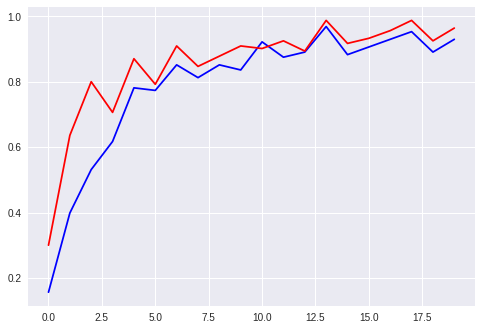

In [23]:
import matplotlib.pyplot as plt
Length=range(len(BaseTrain))
plt.plot(Length,BaseTrain,'b',Length,BoundedTrain,'r')

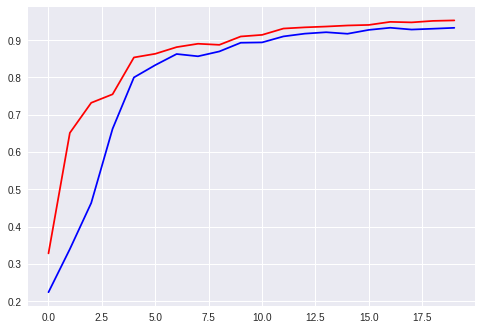

In [22]:
Length=range(len(BaseTest))
plt.plot(Length,BaseTest,'b',Length,BoundedTest,'r')

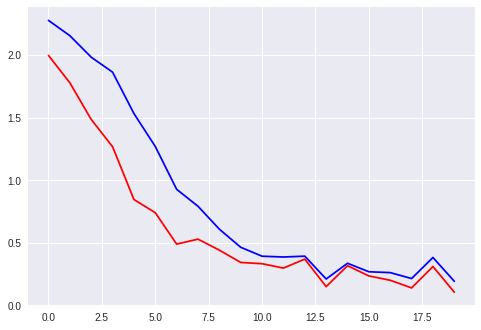

In [28]:
Length=range(len(BaseLoss))
plt.plot(Length,BaseLoss,'b',Length,BoundedLloss,'r')